# Non-Ergodic GMM Regression (Type-3) using STAN, PyStan Library
## Partially Uncorrelated Anelastic Attenuation Cells

This notebook is used to estimate the non-ergodic coefficients, anelastic attenuation coefficients, and hyper-parameters of a type-3 non-ergodic GMM though Gaussian Process regression using the Bayesian software STAN. 


The Type-3 GMM compnents, with uncorrelated anelastic attenuation cells, are:
- The non-ergodic effects are modeled by:
  - $\delta c_{0}$:    constant shift of non-ergodic GMM with respect to base ergodic GMM
  - $\delta c_{1,E}$:  spatially varying eathquake adjustment as a function of the earthquake coordinates
  - $\delta c_{1a,S}$: spatially varying site adjustment as a function of the site coordinates
  - $\delta c_{1b,S}$: spatially independent site adjustment as a function of the station id
  - $c_{2,P}$:         spatially varying geometrical spreading as a function of the earthquake coordinates
  - $c_{3,S}$:         spatially varying $V_{S30}$ scaling as a function of the site coordinates
  - $c_{ca,P}$:        cell-specific anelastic attenuation
- The aleatory variability is captured by:
  - $\delta B^0_{e}$: between-event aleatory term
  - $\delta W^0_{e,s}$: within-event aleatory term
- The non-ergodic hyperparameters are:
  - $\ell_{1,E}$:     correlation lenght of spatially varying earthquake adjustment
  - $\ell_{1a,S}$:    correlation lenght of spatially varying site adjustment
  - $\ell_{2,P}$:     correlation lenght of spatially varying eometrical spreading
  - $\ell_{3,S}$:     correlation lenght of spatially $V_{S30}$ scaling
  - $\omega_{1,E}$:   scale of spatially varying earthquake adjustment 
  - $\omega_{1a,S}$:  scale of spatially varying site adjustment
  - $\omega_{1b,S}$:  scale of spatially independent site adjustment
  - $\omega_{2,P}$:   scale of spatially varying geometrical spreading
  - $\omega_{3,S}$:   scale of spatially varying $V_{S30}$ scaling
  - $\omega_{ca,P}$:  scale of anelastic attenuation cell coefficients
  - $\mu_{2,P}$:      mean of geometrical spreading
  - $\mu_{3,S}$:      mean of $V_{S30}$ scaling
  - $\mu_{ca,P}$:     mean of cell-specific anelastic attenuation   
  - $\tau_{0}$:       standard deviation of between-event aleatory
  - $\phi_{0}$:       standard deviation of within-event aleatory

**Disclaimer:** The non-ergodic regression is perfomed on the total residuals (column ``res_name``) of a base ergodic GMM without including the effect of anelastic attenuation. 
The total regression residuals ($\epsilon_{tot}$) without the effect of geometrical spreading, $V_{S30}$ scalign, and anelastic attenuation are defined as:
$$
\epsilon_{tot} = log(IM) - (\mu_{erg}(M,R_{rup},V_{S30}, ...) - (c_{2~erg} ~ f_{gs}(R_{rup},M) + c_{3~erg} ~ f_{V_{S30}}(V_{S30}) + c_{a~erg} ~ R_{rup})
$$
where $IM$ is the intesity parameter of interest (e.g. PGA, PSA), $\mu_{erg}$ is mean functional form of the ergodic GMM in log space, $c_2$ is the ergodic geometrical spreading coefficient, $c_3$ is the ergodic $V_{S30}$ scaling coefficient, and $c_{a~erg}$ is the ergodic anelastic attenuation coefficient.

This script was developed as part of the Non-ergodic Methodology and Modeling Tools research project summarized in the report by Lavrentiadis G., Kuehn N., Bozorgnia Y., Seylabi E., Meng X., Goulet C., and Kottke A. (2022), "Non‐ergodic Methodology and Modeling Tools (Report GIRS-2022-04)." Natural Hazards Risk and Resiliency Research Center, University of California, Los Angeles.

Support provided by the California Department of Transportation (Caltrans) and Pacific Gas and Electric Company (PG&E). 

## Load required libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#user functions
sys.path.insert(0,'../Python_lib/regression/pystan')
sys.path.insert(0,'../Python_lib/plotting')
import pylib_contour_plots as pycplt

## User Input, Definition of Regression Parameters 
The 1st synthetic dataset based the NGAWest2 CA metadata for the type-3 NGMM is used as an example.
The user should update the variables in this section to point to the regression dataset of interest.

The entire NGAWest3 CA syntethic dataset is loaded in this section and in the preprocessing section only the records that are part of the NGAWest2 CA are kept.

In [2]:
#regression name
reg_name  = 'example_regression_ds3'

#regression dataset
flatfile_fname = '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_synthetic_data_ngmm3_small_corr_len_Y1.csv'
#cell-path info and distance matrix
cellinfo_fname = '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_cellinfo.csv'
celldist_fname = '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_distancematrix.csv'

#output directory
dir_out = '../../Data/Regression/example_ds3_pystan/'

#filename for stan regression code
#dense matrix implementation
sm_fname = '../Stan_lib/regression_stan_model3_uncorr_cells_unbounded_hyp_chol_efficient.stan'
from regression_pystan_model3_uncorr_cells_unbounded_hyp import RunStan
# #sparse matrix implementation
# sm_fname = '../Stan_lib/regression_stan_model3_uncorr_cells_sparse_unbounded_hyp_chol_efficient.stan'
# from regression_pystan_model3_uncorr_cells_sparse_unbounded_hyp import RunStan

#STAN parameters
runstan_flag  = True
pystan_ver    = 2
res_name      = 'tot'
n_iter        = 1000
n_chains      = 4
adapt_delta   = 0.8
max_treedepth = 10
#parallel options
# flag_parallel = True
flag_parallel = False
#ergodic coefficients
c_2_erg=-2.0
c_3_erg=-0.6
c_a_erg=0.0

## Load Files

In [3]:
#load flatfile
df_flatfile = pd.read_csv(flatfile_fname)

#load cell dataframes
df_cellinfo = pd.read_csv(cellinfo_fname)
df_celldist = pd.read_csv(celldist_fname)

## Preprocessing 
This section can be used by the user for any pre-porcessing steps of the regression dataset.

In [4]:
#keep only North records of NGAWest2
df_flatfile = df_flatfile.loc[df_flatfile.dsid==0,:]

## Run Regression

In [5]:
print(f'Running regression for:%s'%(reg_name))

#run time start
run_t_strt = time.time()

#run stan model
RunStan(df_flatfile, df_cellinfo, df_celldist, sm_fname, 
        reg_name, dir_out, res_name,
        c_2_erg=c_2_erg, c_3_erg=c_3_erg, c_a_erg=c_a_erg, 
        runstan_flag=runstan_flag, n_iter=n_iter, n_chains=n_chains,
        adapt_delta=adapt_delta, max_treedepth=max_treedepth,
        pystan_ver=pystan_ver, pystan_parallel=flag_parallel)
       
#run time end
run_t_end = time.time()

#compute run time
run_tm = (run_t_end - run_t_strt)/60
  
#log run time
df_run_info = pd.DataFrame({'computer_name':os.uname()[1],'reg_name':reg_name,'run_time':run_tm}, 
                            index=[1])
                           
#write out run info
fname_reginfo   = '%s/run_info.csv'%(dir_out)
df_run_info.reset_index(drop=True).to_csv(fname_reginfo, index=False)

print(f'Completed regression for: %s'%(reg_name))

Running regression for:example_regression_ds3
max R_rup misfit 1.7479351299698465e-12


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_040e555fbd69597bb7934d4ae1867e1d NOW.
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.cpp:777:
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #w

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.

In file included from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/pystan/py_var_context.hpp:12,
                 from /tmp/pystan_dd9jfcwk/stanfit4anon_model_040e555fbd69597bb7934d4ae1867e1d_8335666746060741180.


Gradient evaluation took 3.40906 seconds
1000 transitions using 10 leapfrog steps per transition would take 34090.6 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 4.09059 seconds
1000 transitions using 10 leapfrog steps per transition would take 40905.9 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 4.49871 seconds
1000 transitions using 10 leapfrog steps per transition would take 44987.1 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 6.17981 seconds
1000 transitions using 10 leapfrog steps per transition would take 61798.1 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis propos

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis propos

Iteration: 1 / 10 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1 / 10 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1 / 10 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 6 / 10 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis prop

Iteration: 10 / 10 [100%]  (Sampling)
Iteration: 1 / 10 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = -nan, but A[2,1] = -nan  (in 'unknown file name' at line 128)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 32.792 seconds (Warm-up)
               22.1535 seconds (Sampling)
               54.9454 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 6 / 10 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 6 / 10 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in 'unknown file name' at line 183)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in 'unknown file name' at line 183)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because o

Iteration: 10 / 10 [100%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in 'unknown file name' at line 183)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 10 / 10 [100%]  (Sampling)

 Elapsed Time: 35.4736 seconds (Warm-up)
               38.3598 seconds (Sampling)
               73.8334 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite  (in 'unknown file name' at line 183)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 53.4404 seconds (Warm-up)
               28.9915 seconds (Sampling)
               82.4318 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf  (in 'unknown file name' at line 147)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal

Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 10 / 10 [100%]  (Sampling)

 Elapsed Time: 1673.82 seconds (Warm-up)
               47.8573 seconds (Sampling)
               1721.68 seconds (Total)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/mnt/halcloud_nfs/glavrent/Research/NHR3_repos/ngmm_tools/Analyses/Regression/../Python_lib/regression/pystan/regression_pystan_model3_uncorr_cells_unbounded_hyp.py:213: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump({'model' : stan_model, 'fit' : stan_fit}, f, protocol=-1)
/mnt/halcloud_nfs/glavrent/Research/NHR3_repos/ngmm_tools/Analyses/Regression/../Python_lib/regression/pystan/regression_pystan_model3_uncorr_cells_unbounded_hyp.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stan_hyp = df_stan_hyp.append(df_stan_posterior_raw[col_names_hyp].mean(axis = 0), ignore_index=True)
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - 

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - 

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/g

Completed regression for: example_regression_ds3


## Regression Review
The next code chunks produce summary plots to review the regression fit

In [6]:
%matplotlib inline

#load non-ergodic coefficients and residuals
fname_hparam  = dir_out + reg_name + '_stan_hyperparameters.csv'
fname_gmotion = dir_out + reg_name + '_stan_residuals.csv'
fname_coeff   = dir_out + reg_name + '_stan_coefficients.csv'
fname_atten   = dir_out + reg_name + '_stan_catten.csv'

df_hparam  = pd.read_csv(fname_hparam, index_col=0)
df_gmotion = pd.read_csv(fname_gmotion, index_col=0)
df_coeff   = pd.read_csv(fname_coeff, index_col=0)
df_atten   = pd.read_csv(fname_atten, index_col=0)

#merge gm-flatfile with non-ergodic coeffs and res 
df_gmotion = pd.merge(df_flatfile[['mag','Rrup','Vs30']], df_gmotion, left_index=True, right_index=True)
df_coeff   = pd.merge(df_flatfile[['mag','Rrup','Vs30']], df_coeff,   left_index=True, right_index=True)
#merge cell atten coeffs with cell atten info
df_atten   = pd.merge(df_cellinfo, df_atten[['c_cap_mean','c_cap_med','c_cap_sig']], 
                      left_index=True, right_index=True)

#print mean and standard deviations of aleatory terms
print(f'Between-event mean:\t %.3f'%df_gmotion.res_between.mean())
print(f'Within-event mean:\t %.3f'%df_gmotion.res_within.mean())
print(f'Between-event std:\t %.3f'%df_gmotion.res_between.std())
print(f'Within-event std:\t %.3f'%df_gmotion.res_within.std())

Between-event mean:	 -0.049
Within-event mean:	 157.993
Between-event std:	 0.581
Within-event std:	 108.762


### Non-ergodic Residuals

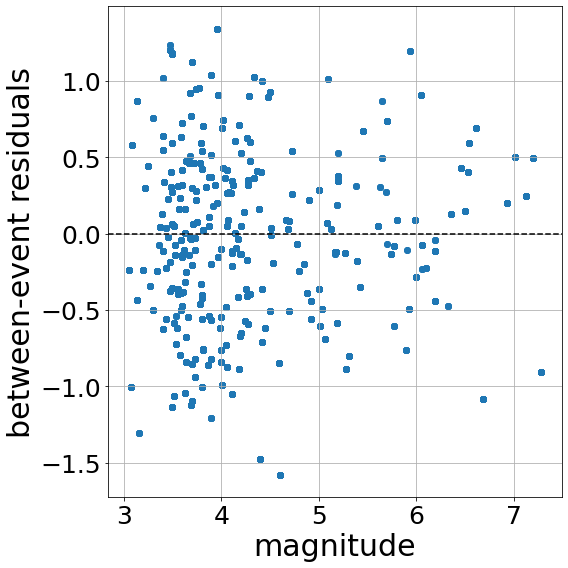

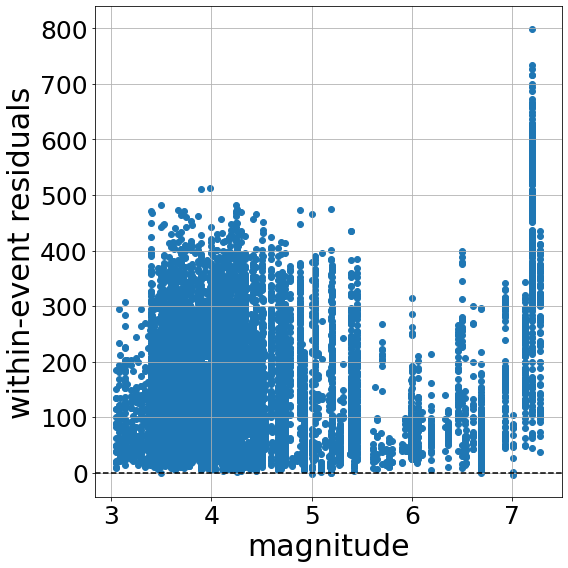

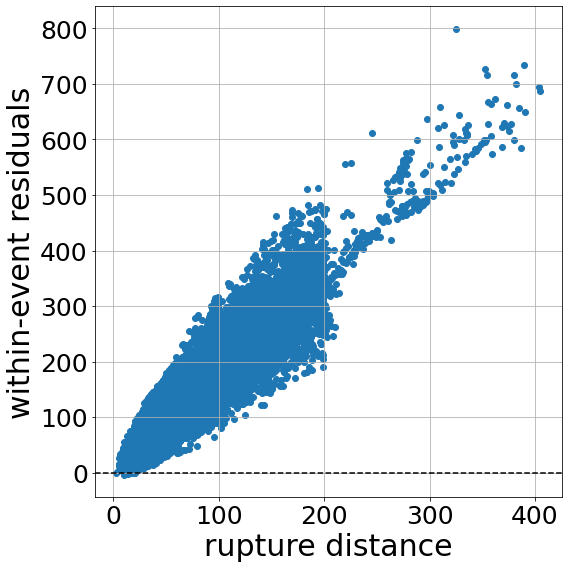

In [7]:
#between-event residuals 
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_gmotion.mag, df_gmotion.res_between)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel('magnitude',               fontsize=30)
ax.set_ylabel('between-event residuals', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

#within-event residuals vs mag
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_gmotion.mag, df_gmotion.res_within)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel('magnitude',               fontsize=30)
ax.set_ylabel('within-event residuals', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

#within-event residuals vs dist
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_gmotion.Rrup, df_gmotion.res_within)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel('rupture distance',       fontsize=30)
ax.set_ylabel('within-event residuals', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

### Non-ergodic Coefficients

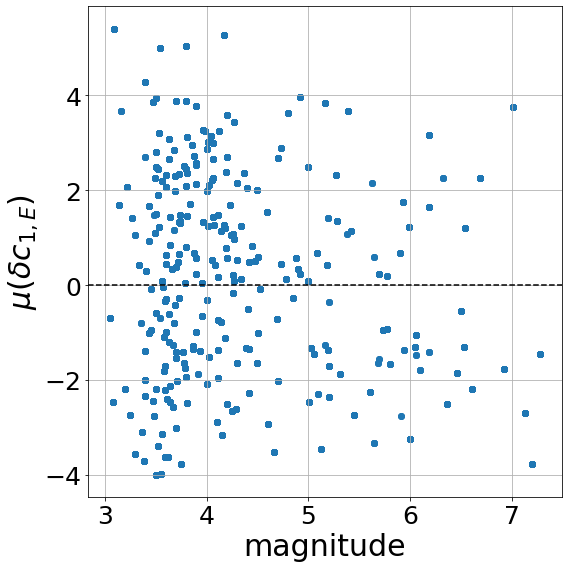

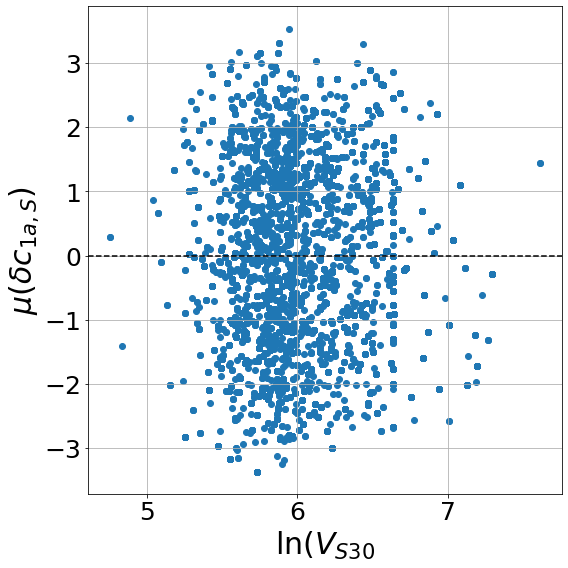

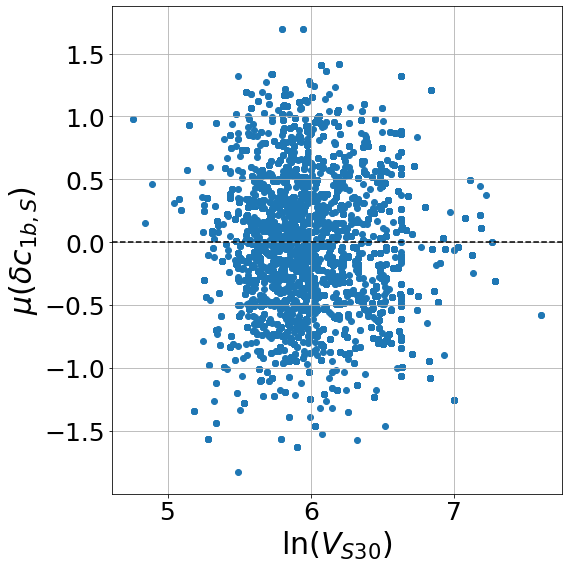

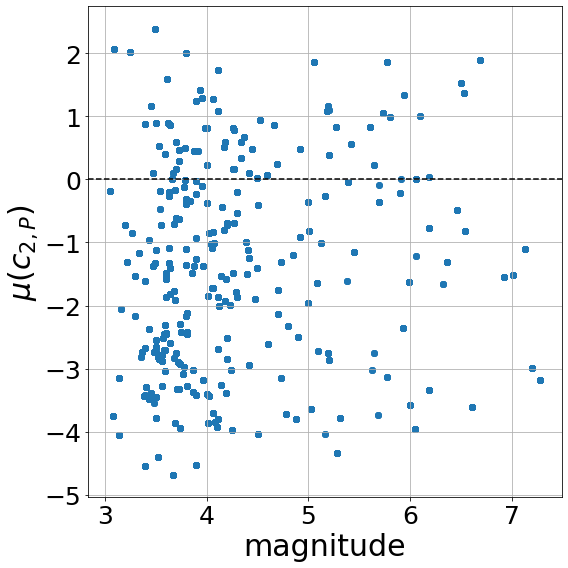

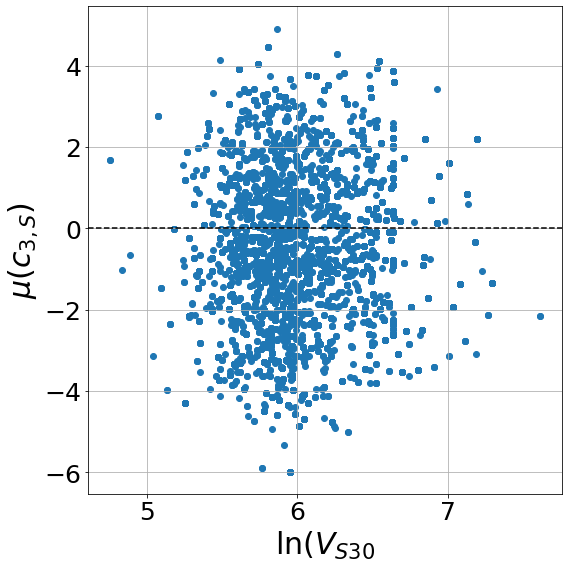

In [8]:
#spatially varying earthquake adjustment
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_coeff.mag, df_coeff.dc_1e_mean)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel('magnitude',              fontsize=30)
ax.set_ylabel(r'$\mu(\delta c_{1,E})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

#spatially varying site adjustment
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(np.log(df_coeff.Vs30), df_coeff.dc_1as_mean)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel(r'$\ln(V_{S30}$',          fontsize=30)
ax.set_ylabel(r'$\mu(\delta c_{1a,S})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

#spatially varying site adjustment
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(np.log(df_coeff.Vs30), df_coeff.dc_1bs_mean)
ax.axhline(y=0, color='black', linestyle='--')
#figure properties
ax.set_xlabel(r'$\ln(V_{S30})$',         fontsize=30)
ax.set_ylabel(r'$\mu(\delta c_{1b,S})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

In [ ]:
#spatially varying geometrical spreading
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_coeff.mag, df_coeff.c_2p_mean)
ax.axhline(y=df_hparam.loc['mean','mu_2p'], color='black', linestyle='--')
#figure properties
ax.set_xlabel('magnitude',              fontsize=30)
ax.set_ylabel(r'$\mu(c_{2,P})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

#spatially varying Vs30 term
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(np.log(df_coeff.Vs30), df_coeff.c_3s_mean)
ax.axhline(y=df_hparam.loc['mean','mu_3s'], color='black', linestyle='--')
#figure properties
ax.set_xlabel(r'$\ln(V_{S30}$',          fontsize=30)
ax.set_ylabel(r'$\mu(c_{3,S})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is depre

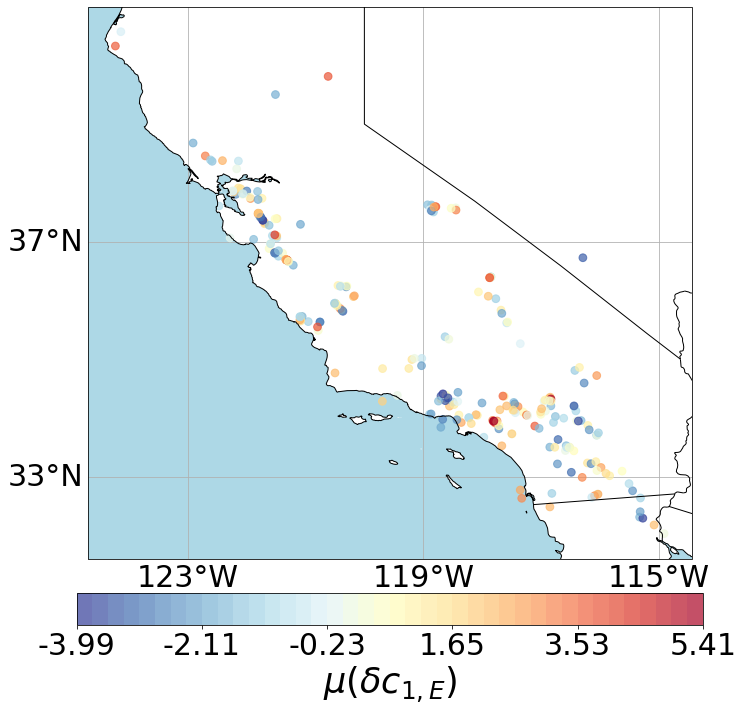

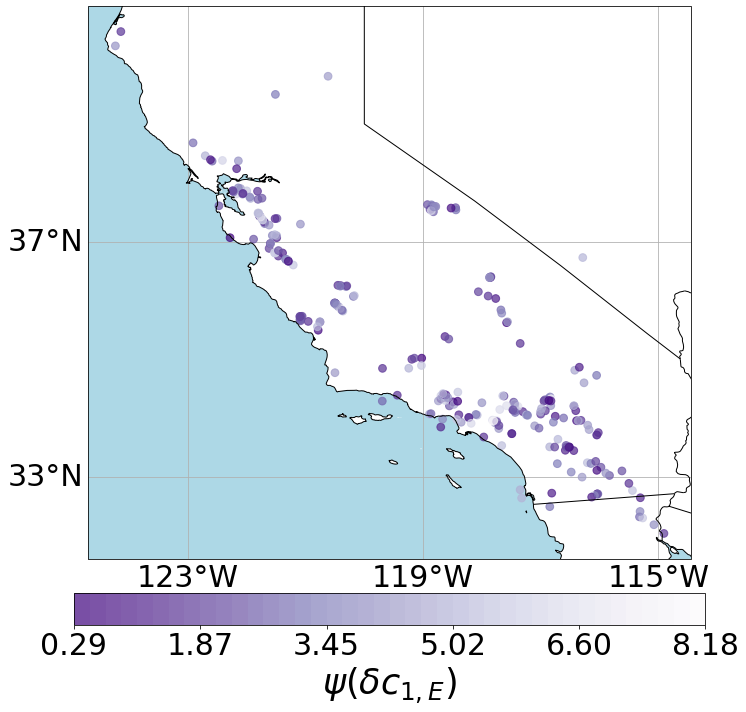

In [9]:
#earthquake indices
_, eq_idx  = np.unique(df_coeff[['eqid']].values, axis=0, return_index=True)
#station indices
_, sta_idx = np.unique(df_coeff[['ssn']].values, axis=0, return_index=True)

#spatially varying earthquake adjustment
#---------------------
#mean
#---   ---   ---   ---
cbar_label = r'$\mu(\delta c_{1,E})$'
data2plot  = df_coeff[['eqLat','eqLon','dc_1e_mean']].values[eq_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='RdYlBu_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

#epistemic uncertainty
#---   ---   ---   ---
cbar_label = r'$\psi(\delta c_{1,E})$'
data2plot  = df_coeff[['eqLat','eqLon','dc_1e_sig']].values[eq_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='Purples_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is depre

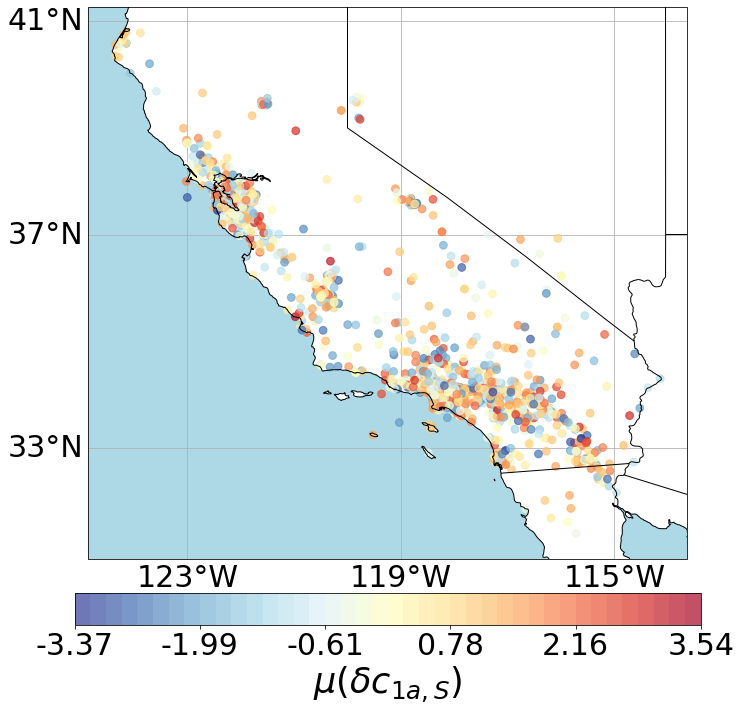

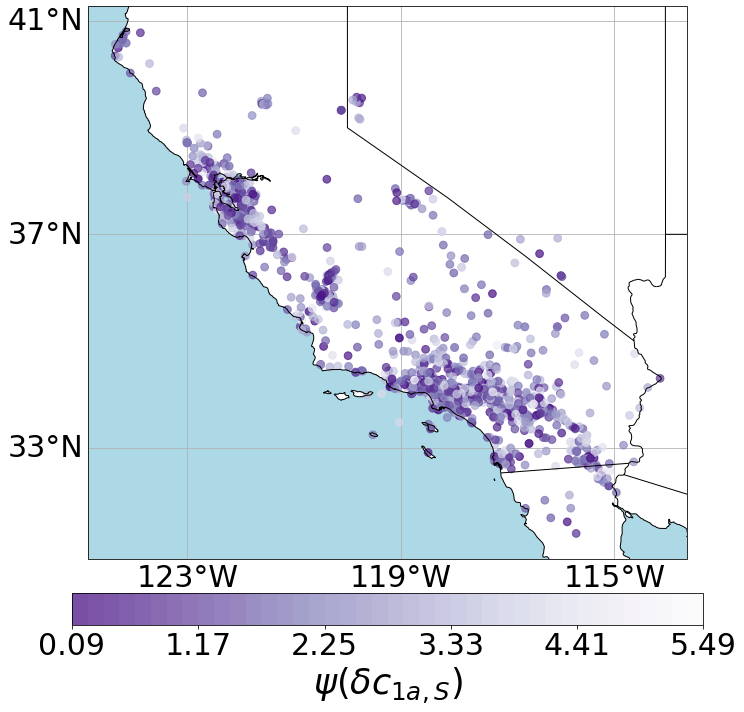

In [10]:
#spatially varying site adjustment
#---------------------
#mean
#---   ---   ---   ---
cbar_label = r'$\mu(\delta c_{1a,S})$'
data2plot  = df_coeff[['staLat','staLon','dc_1as_mean']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='RdYlBu_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

#epistemic uncertainty
#---   ---   ---   ---
cbar_label = r'$\psi(\delta c_{1a,S})$'
data2plot  = df_coeff[['staLat','staLon','dc_1as_sig']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='Purples_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/glavrent/anaconda3/envs/python_3.8stan2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is depre

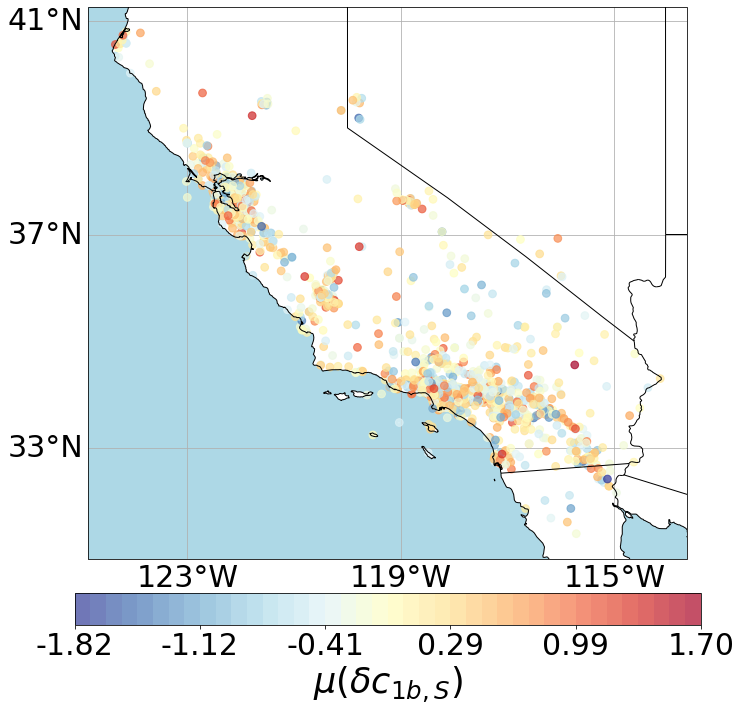

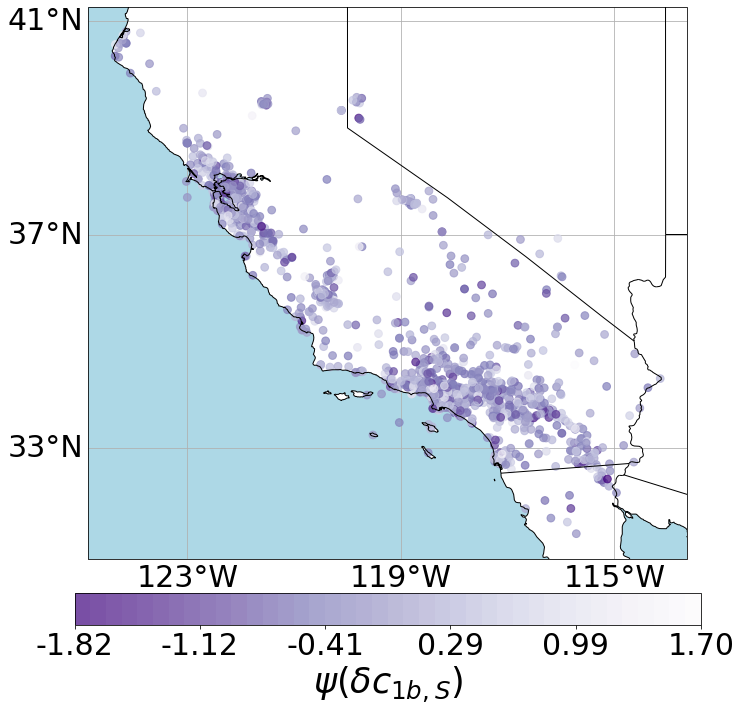

In [11]:
#spatially independent site adjustment
#---------------------
#mean
#---   ---   ---   ---
cbar_label = r'$\mu(\delta c_{1b,S})$'
data2plot  = df_coeff[['staLat','staLon','dc_1bs_mean']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='RdYlBu_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

#epistemic uncertainty
#---   ---   ---   ---
cbar_label = r'$\psi(\delta c_{1b,S})$'
data2plot  = df_coeff[['staLat','staLon','dc_1bs_mean']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='Purples_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

In [12]:
#spatially varying geometrical spreading
#---------------------
#mean
#---   ---   ---   ---
cbar_label = r'$\mu(c_{2,P})$'
data2plot  = df_coeff[['eqLat','eqLon','c_2p_mean']].values[eq_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='RdYlBu_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

#epistemic uncertainty
#---   ---   ---   ---
cbar_label = r'$\psi(c_{2,P})$'
data2plot  = df_coeff[['eqLat','eqLon','c_2p_sig']].values[eq_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='Purples_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

KeyError: "['dc_2p_mean'] not in index"

In [ ]:
#spatially varying Vs30 term
#---------------------
#mean
#---   ---   ---   ---
cbar_label = r'$\mu(c_{3,S})$'
data2plot  = df_coeff[['staLat','staLon','c_3s_mean']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='RdYlBu_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

#epistemic uncertainty
#---   ---   ---   ---
cbar_label = r'$\psi(c_{3,S})$'
data2plot  = df_coeff[['staLat','staLon','c_3s_sig']].values[sta_idx,:]
fig, ax, cbar, data_crs, _ = pycplt.PlotScatterCAMap(data2plot, cmap='Purples_r', log_cbar=False, marker_size=60,
                                                     frmt_clb = '%.2f')
#update colorbar 
cbar.ax.tick_params(tick1On=1, labelsize=30)
cbar.set_label(cbar_label, size=35)
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
gl.xlocator = mticker.FixedLocator([-123, -119, -115])
gl.ylocator = mticker.FixedLocator([ 33,   37,   41])
#apply tight layout
fig.tight_layout()

### Cell-specific Anelastic Attenuation

In [ ]:
#cell-specific anelastic attenuation: mean versus std 
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df_atten.c_cap_sig, df_atten.c_cap_mean)
ax.axhline(y=df_hparam.loc['mean','mu_cap'], color='black', linestyle='--')
#figure properties
ax.set_xlabel(r'$\psi(c_{ca,P})$', fontsize=30)
ax.set_ylabel(r'$\mu(c_{ca,P})$', fontsize=30)
ax.grid(which='both')
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
fig.tight_layout()

In [ ]:
cbar_label = r'$\mu(c_{ca,P}$)'
data2plot = df_atten[['mptLat','mptLon','c_cap_mean']].values
#create figure
fig, ax, cbar, data_crs, gl = pycplt.PlotCellsCAMapMed(data2plot)
#plot cells
#cell coordinates
cell_latlon_edge = df_cellinfo[['q5Lat','q5Lon','q6Lat','q6Lon','q8Lat','q8Lon', 
                                'q7Lat','q7Lon','q5Lat','q5Lon']].values
for ce_xy in cell_latlon_edge:
    ax.plot(ce_xy[[1,3,5,7,9]],ce_xy[[0,2,4,6,8]], color='gray', transform=data_crs)
#figure limits
#ax.set_xlim( fig_latlon_win[:,1] )
#ax.set_ylim( fig_latlon_win[:,0] )
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
#update colorbar 
cbar.set_label(cbar_label, size=30)
cbar.ax.tick_params(labelsize=25)
#apply tight layout
#fig.show()
fig.tight_layout()

cbar_label = r'$\psi(c_{ca,P}$)'
data2plot = df_atten[['mptLat','mptLon','c_cap_sig']].values
#create figure
fig, ax, cbar, data_crs, gl = pycplt.PlotCellsCAMapSig(data2plot)
#plot cells
#cell coordinates
cell_latlon_edge = df_cellinfo[['q5Lat','q5Lon','q6Lat','q6Lon','q8Lat','q8Lon', 
                                'q7Lat','q7Lon','q5Lat','q5Lon']].values
for ce_xy in cell_latlon_edge:
    ax.plot(ce_xy[[1,3,5,7,9]],ce_xy[[0,2,4,6,8]], color='gray', transform=data_crs)
#figure limits
#ax.set_xlim( fig_latlon_win[:,1] )
#ax.set_ylim( fig_latlon_win[:,0] )
#grid lines
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
#update colorbar 
cbar.set_label(cbar_label, size=30)
cbar.ax.tick_params(labelsize=25)
#apply tight layout
#fig.show()
fig.tight_layout()